# Reinforcement Learning Project

## Environment - Atari: Adventure

**Action Space**

The action space is **discrete with 18 possible actions**, consistent across Atari environments using the **ALE (Arcade Learning Environment)** interface. However, for *Adventure*, not all 18 actions have distinct effects. Commonly used actions include:

* 0: NOOP (no operation)
* 1: FIRE (start the game / interact)
* 2: UP
* 3: RIGHT
* 4: LEFT
* 5: DOWN
* Other actions (6-17) are combinations or duplicates, often ignored by learning agents for *Adventure*.

**Observation Space**

The observation is a 3D RGB image representing the current game screen. The shape is (210, 160, 3). For training, this image is often preprocessed:

- Converted to grayscale
- Resized to 84×84 pixels
- Stacked across 4 consecutive frames to capture motion

This results in a commonly used processed observation shape of (84, 84, 4).

**Rewards**

* Rewards are game-specific. For *Adventure*, rewards are sparse and tied to in-game objectives:

  * **+1**: Picking up a key, sword, or chalice
  * **+1**: Unlocking a castle
  * **+1**: Killing a dragon
  * **+1**: Returning the chalice to the gold castle (final objective)
  * Some events may not give reward despite importance due to original game limitations.

**Starting State**

* The player begins near the Yellow Castle.
* The game state (items, enemies, doors) is initialized with a fixed or semi-random configuration, depending on the game difficulty level (there are 3 game modes: random vs fixed map/object spawns).

**Episode Termination**

The episode ends when:

* The **player successfully returns the chalice to the Gold Castle**.
* A **maximum number of steps** is reached (usually 108,000 frames in standard ALE).
* The **agent loses all lives**, although *Adventure* does not have traditional lives like platformers.

**Version**

* V5 (via Gym/MinAtar/ALE integration)

**Objective**

* Retrieve the **enchanted chalice** and return it to the **Gold Castle**.
* Use keys to open castles, avoid or defeat dragons, and explore the game map.

## Environment Setup Note

To use the Atari environments (e.g., `"ALE/Adventure-v5"`), install the compatible Gym version:

```bash
pip install gym==0.26.2 "gym[atari,accept-rom-license]"

## Libraries

In [1]:
import gym
from stable_baselines3 import DQN, A2C, PPO
import matplotlib.pyplot as plt
import numpy as np

from utils import run_episodes

In [3]:
!pip install "stable-baselines3[extra]"

  Using cached stable_baselines3-2.6.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached matplotlib-3.10.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl.metadata (20 kB)
  Using cached pygame-2.6.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached pillow-11.2.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (8.9 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached absl

In [4]:
import gymnasium as gym
from stable_baselines3 import DQN, A2C, PPO
import matplotlib.pyplot as plt
import numpy as np

from utils import run_episodes

## Environment

In [13]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

env = gym.make('ALE/Adventure-v5')  # remove render_mode in training

In [5]:
env = gym.make("ALE/Adventure-v5")
obs, info = env.reset()

print("Environment loaded successfully!")
print("Observation shape:", obs.shape)

#env.close()

NamespaceNotFound: Namespace ALE not found. Have you installed the proper package for ALE?

In [3]:
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Observation Space: Box(0, 255, (250, 160, 3), uint8)
Action Space: Discrete(18)


In [12]:
# minimal_go_explore_adventure.py
#import gym
from minimal_goexplore import Explorer, Cell  # from ryanrudes/minimal_goexplore

def main():
    env = gym.make("ALE/Adventure-v5")  # adventure environment :contentReference[oaicite:1]{index=1}
    explorer = Explorer(env, max_steps=100_000, render=False)

    # define simple cell representation, e.g., low-res image hash
    def cell_fn(obs):
        return hash(obs[::20, ::20, :].tobytes())

    explorer.cell_fn = cell_fn

    # run exploration to build archive
    archive = explorer.explore()

    # pick best trajectory (e.g., highest score) and replay it
    best = max(archive.values(), key=lambda c: c.score)
    print(f"Best score: {best.score}, steps: {len(best.actions)}")
    obs = env.reset()
    for a in best.actions:
        obs, r, done, _ = env.step(a)
        env.render()
        if done:
            break

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'minimal_goexplore'

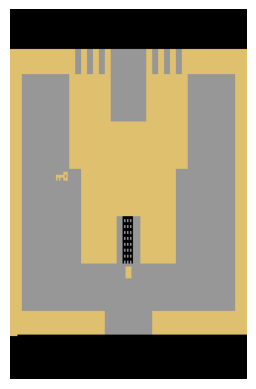

In [4]:
import matplotlib.pyplot as plt

plt.imshow(obs)
plt.axis('off')
plt.show()

# Preprocessing

Atari environments return raw pixel observations shaped like (210, 160, 3) (RGB), which are:

- Large in size (high memory & compute cost)
- Full of irrelevant visual details (e.g., score, borders, flicker)
- Temporally unstable (a single frame doesn’t show motion clearly)

What happens if we don’t preprocess? Training becomes very slow, or fails completely; the network will have a hard time extracting useful features and It may overfit to noise or irrelevant screen elements.

In [5]:
from PIL import Image
from gym import ObservationWrapper
from gym.spaces import Box

class AtariPreprocessingWrapper(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = Box(low=0.0, high=1.0, shape=(84, 84), dtype=np.float32)

    def observation(self, obs):
        obs = Image.fromarray(obs)
        obs = obs.convert('L')  # grayscale
        obs = obs.resize((84, 84))  # downsample
        obs = np.array(obs, dtype=np.float32) / 255.0  # normalize
        return obs

In [6]:
env = AtariPreprocessingWrapper(env)

In [7]:
from gym.wrappers import FrameStack
env = FrameStack(env, 4)

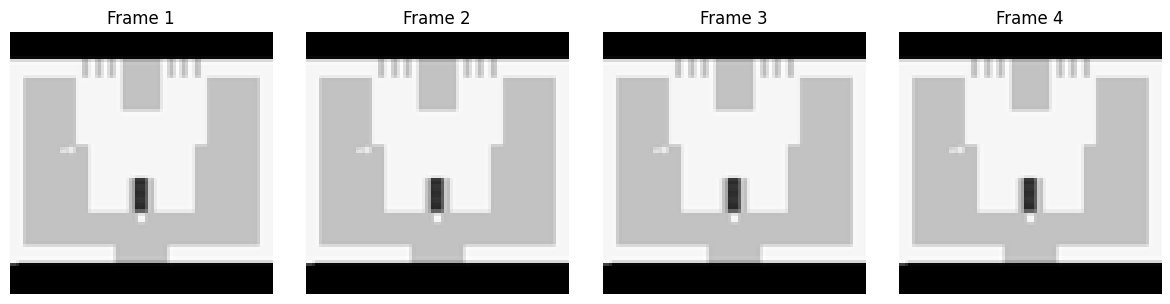

In [8]:
import matplotlib.pyplot as plt

obs, _ = env.reset()  # obs will be shape: (4, 84, 84)

# Plot each stacked frame
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axes[i].imshow(obs[i], cmap='gray')
    axes[i].set_title(f'Frame {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Preprocess frames (resize + grayscale)
def preprocess(obs):
    obs = Image.fromarray(obs)
    obs = obs.convert('L')  # grayscale
    obs = obs.resize((84, 84))  # downsample
    obs = np.array(obs) / 255.0  # normalize
    return obs

| Preprocessing Step                   | Why It's Done                                                  |
| ------------------------------------ | -------------------------------------------------------------- |
| **Grayscale**                        | Removes color, reducing input from 3 to 1 channel              |
| **Resizing (e.g., 210×160 → 84×84)** | Smaller input = faster training and less memory usage          |
| **Frame Stacking**                   | Shows motion by combining multiple consecutive frames          |
| **Pixel Normalization**              | Stabilizes training (values in `[0, 1]` instead of `[0, 255]`) |

## Solving the Environment

In [8]:
import gym
from gym.wrappers import GrayScaleObservation, ResizeObservation, FrameStack
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

env = gym.make("ALE/Adventure-v5", render_mode="rgb_array")
env = ResizeObservation(env, (84, 84))
env = GrayScaleObservation(env)
env = FrameStack(env, 4)  # frame stacking
env = DummyVecEnv([lambda: env])  # SB3 requires VecEnv

/opt/anaconda3/envs/rl/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [11]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.atari_wrappers import wrap_deepmind

env = make_atari_env("AdventureNoFrameskip-v4", n_envs=1, seed=42)
env = wrap_deepmind(env, frame_stack=True)

model = DQN("CnnPolicy", env, verbose=1, seed=42, tensorboard_log="./logs/")

model.learn(total_timesteps=1000)

# Rewrap for inference (remove VecEnv)
env_for_eval = make_atari_env("AdventureNoFrameskip-v4", n_envs=1, seed=123)
env_for_eval = wrap_deepmind(env_for_eval, frame_stack=True)

rewards_dqn = run_episodes(model, env_for_eval, n_episodes=10)

ImportError: cannot import name 'wrap_deepmind' from 'stable_baselines3.common.atari_wrappers' (/opt/anaconda3/envs/shhh/lib/python3.10/site-packages/stable_baselines3/common/atari_wrappers.py)

In [7]:
from stable_baselines3.common.atari_wrappers import AtariWrapper

env = gym.make("ALE/Adventure-v5", render_mode="rgb_array")
env = AtariWrapper(env)

In [9]:
model = DQN("CnnPolicy", env, verbose=1, seed=42)

timestamps = 100_000 

model.learn(total_timesteps=timestamps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/opt/anaconda3/envs/shhh/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.13GB > 1.34GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.32e+03 |
|    ep_rew_mean      | 0        |
|    exploration_rate | 0.497    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 70       |
|    time_elapsed     | 74       |
|    total_timesteps  | 5296     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.54e-07 |
|    n_updates        | 1298     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.14e+03 |
|    ep_rew_mean      | 0        |
|    exploration_rate | 0.13     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 70       |
|    time_elapsed     | 129      |
|    total_timesteps  | 9159     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.27e-07 |
|    n_updates      

In [10]:
episodes = 1000

rewards_dqn = run_episodes(model, env, n_episodes=episodes)

Episode 1: Reward = 0.00
Episode 2: Reward = 0.00
Episode 3: Reward = 0.00
Episode 4: Reward = 0.00
Episode 5: Reward = 0.00
Episode 6: Reward = 0.00
Episode 7: Reward = 0.00
Episode 8: Reward = 0.00
Episode 9: Reward = 0.00
Episode 10: Reward = 0.00
Episode 11: Reward = 0.00
Episode 12: Reward = 0.00
Episode 13: Reward = 0.00
Episode 14: Reward = 0.00
Episode 15: Reward = 0.00
Episode 16: Reward = 0.00
Episode 17: Reward = 0.00
Episode 18: Reward = 0.00
Episode 19: Reward = 0.00
Episode 20: Reward = 0.00
Episode 21: Reward = 0.00
Episode 22: Reward = 0.00
Episode 23: Reward = 0.00
Episode 24: Reward = 0.00
Episode 25: Reward = 0.00
Episode 26: Reward = 0.00
Episode 27: Reward = 0.00
Episode 28: Reward = 0.00
Episode 29: Reward = 0.00
Episode 30: Reward = 0.00
Episode 31: Reward = 0.00
Episode 32: Reward = 0.00
Episode 33: Reward = 0.00
Episode 34: Reward = 0.00
Episode 35: Reward = 0.00
Episode 36: Reward = 0.00
Episode 37: Reward = 0.00
Episode 38: Reward = 0.00
Episode 39: Reward = 

KeyboardInterrupt: 

In [19]:
def run_episodes(model, env, n_episodes=10):
    episode_rewards = []

    for episode in range(n_episodes):
        obs = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            total_reward += reward[0]  # reward is a vector (even if batch size = 1)
            
            if done:
                break

        episode_rewards.append(total_reward)

    return episode_rewards

In [20]:
episodes = 1000

rewards_dqn = run_episodes(model, env, n_episodes=episodes)

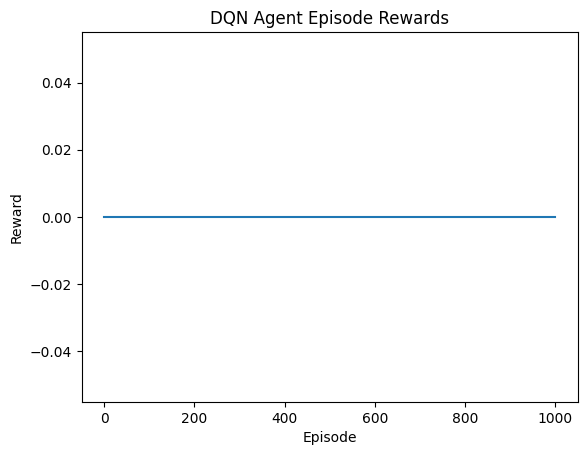

In [21]:
plt.plot(rewards_dqn)
plt.title("DQN Agent Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [1]:
from ale_py import ALEInterface, roms

ale = ALEInterface()
ale.loadROM(roms.get_rom_path("breakout"))
ale.reset_game()

reward = ale.act(0)  # noop
screen_obs = ale.getScreenRGB()

A.L.E: Arcade Learning Environment (version 0.11.1+2750686)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/shhh/lib/python3.10/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 1750247406


In [3]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)  # unnecessary but helpful for IDEs

env = gym.make('ALE/Adventure-v5', render_mode="human")  # remove render_mode in training

In [12]:
pip show gymnasium

Name: gymnasium
Version: 1.1.1
Summary: A standard API for reinforcement learning and a diverse set of reference environments (formerly Gym).
Home-page: https://farama.org
Author: 
Author-email: Farama Foundation <contact@farama.org>
License: MIT License
Location: /opt/anaconda3/envs/shhh/lib/python3.10/site-packages
Requires: cloudpickle, farama-notifications, numpy, typing-extensions
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import gymnasium as gym
from gymnasium.wrappers import FrameStack

def make_env(env_name, ocatari=False):
    env = gym.make(env_name, obs_type='rgb', frameskip=4, full_action_space=True)
    env = AtariPreprocessing(env, grayscale_obs=True, scale_obs=True)
    env = FrameStack(env, 4)
    if ocatari:
        from oc_atari import OCAtariWrapper
        env = OCAtariWrapper(env)
    return env

ModuleNotFoundError: No module named 'gymnasium.wrappers.frame_stack'

In [ ]:
import torch, random, numpy as np

class DQNAgent:
    def __init__(self, env, rainbow=False):
        self.state_shape = env.observation_space.shape
        self.n_actions = env.action_space.n
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.rainbow = rainbow
        self.q_net = build_model(self.state_shape, self.n_actions, rainbow).to(self.device)
        self.target_net = build_model(self.state_shape, self.n_actions, rainbow).to(self.device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=1e-4)
        self.memory = deque(maxlen=100000)
        self.batch_size = 32
        self.gamma = 0.99
        self.epsilon = 1.0
        self.eps_min = 0.1
        self.eps_decay = 1e-6
        self.update_freq = 1000
        self.learn_step = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.n_actions)
        state_v = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        q = self.q_net(state_v)
        return int(q.argmax().item())

    def push(self, s, a, r, ns, d):
        self.memory.append((s, a, r, ns, d))

    def update(self):
        if len(self.memory) < self.batch_size: return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, nxts, dones = zip(*batch)
        # preprocessing omitted...
        # compute current & target Q
        # use Double Q if rainbow
        # loss = ...
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.learn_step % self.update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())
        self.learn_step += 1
        self.epsilon = max(self.eps_min, self.epsilon - self.eps_decay)

    def save(self, path): torch.save(self.q_net.state_dict(), path)


In [ ]:
import torch.nn as nn

def build_model(input_shape, n_actions, rainbow=False):
    c, h, w = input_shape
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv = nn.Sequential(
                nn.Conv2d(c, 32, 8, 4), nn.ReLU(),
                nn.Conv2d(32, 64, 4, 2), nn.ReLU(),
                nn.Conv2d(64, 64, 3, 1), nn.ReLU(),
                nn.Flatten()
            )
            self.fc = nn.Sequential(nn.Linear(self._conv_out(h, w), 512), nn.ReLU())
            if rainbow:
                # distributional output with atoms, noisy-net, dueling...
                pass
            else:
                self.head = nn.Linear(512, n_actions)
        def _conv_out(self, h, w):
            o = self.conv(torch.zeros(1, c, h, w))
            return int(o.shape[1])
        def forward(self, x):
            x = self.conv(x / 255.)
            x = self.fc(x)
            return self.head(x)
    return Net()

In [ ]:
import gymnasium as gym

def train(env_name='ALE/Adventure-v5', use_rainbow=False):
    env = make_env(env_name)
    agent = DQNAgent(env, rainbow=use_rainbow)
    n_frames = 10_000_000
    state = env.reset()[0]
    for frame_idx in range(1, n_frames+1):
        action = agent.select_action(state)
        nxt, reward, done, _, = env.step(action)
        agent.push(state, action, reward, nxt, done)
        state = nxt
        agent.update()
        if done:
            state = env.reset()[0]
        if frame_idx % 100_000 == 0:
            agent.save(f'ckpt_{frame_idx}.pth')
    env.close()

if __name__=='__main__':
    train(use_rainbow=True)

ModuleNotFoundError: No module named 'wrappers'

In [19]:
class DQN(nn.Module):
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),  # input: 4 stacked frames
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * 64, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        return self.net(x)


In [23]:
num_actions = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DQN(num_actions).to(device)
target_net = DQN(num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
memory = deque(maxlen=100_000)

In [24]:
def train_dqn():
    batch_size = 32
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.1
    epsilon_decay = 0.995
    update_target_every = 1000

    frame_stack = deque(maxlen=4)
    total_steps = 0

    for episode in range(5000):
        obs, _ = env.reset()
        obs = preprocess(obs)
        frame_stack = [obs] * 4  # initial 4-frame stack

        done = False
        total_reward = 0

        while not done:
            total_steps += 1
            state = torch.tensor(np.array(frame_stack), dtype=torch.float32).unsqueeze(0).cuda()

            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = policy_net(state)
                    action = torch.argmax(q_values).item()

            next_obs, reward, done, truncated, _ = env.step(action)
            next_obs = preprocess(next_obs)
            frame_stack.append(next_obs)

            next_state = torch.tensor(np.array(frame_stack), dtype=torch.float32).unsqueeze(0).cuda()
            memory.append((state, action, reward, next_state, done))

            total_reward += reward

            # Training step
            if len(memory) > batch_size:
                minibatch = random.sample(memory, batch_size)
                states, actions, rewards, next_states, dones = zip(*minibatch)

                states = torch.cat(states)
                next_states = torch.cat(next_states)
                actions = torch.tensor(actions).unsqueeze(1).cuda()
                rewards = torch.tensor(rewards).unsqueeze(1).cuda()
                dones = torch.tensor(dones, dtype=torch.uint8).unsqueeze(1).cuda()

                q_values = policy_net(states).gather(1, actions)
                next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
                targets = rewards + gamma * next_q_values * (1 - dones)

                loss = nn.MSELoss()(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Update target network
            if total_steps % update_target_every == 0:
                target_net.load_state_dict(policy_net.state_dict())

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        print(f"Episode {episode} - Total Reward: {total_reward} - Epsilon: {epsilon:.3f}")


In [25]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
from torchvision import transforms

# Hyperparameters
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY = 1000000
TARGET_UPDATE = 1000
MEMORY_SIZE = 100000
LR = 1e-4
NUM_FRAMES = 500000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocess frames
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((84, 84)),
    transforms.ToTensor()
])

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return (np.stack(state), action, reward, np.stack(next_state), done)

    def __len__(self):
        return len(self.buffer)

class DQN(nn.Module):
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),  # Input is 4 stacked grayscale frames
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        x = x / 255.0  # normalize pixel values
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

def preprocess_frame(frame):
    return preprocess(frame).squeeze(0).numpy()

def stack_frames(stacked_frames, new_frame, is_new_episode):
    frame = preprocess_frame(new_frame)
    if is_new_episode:
        stacked_frames = deque([frame]*4, maxlen=4)
    else:
        stacked_frames.append(frame)
    return np.stack(stacked_frames, axis=0), stacked_frames

def select_action(state, steps_done, policy_net, num_actions):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    if random.random() > eps_threshold:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            return policy_net(state_tensor).max(1)[1].item()
    else:
        return random.randrange(num_actions)

# Initialize
env = gym.make("ALE/Adventure-v5", render_mode=None)
num_actions = env.action_space.n
policy_net = DQN(num_actions).to(device)
target_net = DQN(num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayBuffer(MEMORY_SIZE)

steps_done = 0
episode_rewards = []

for episode in range(500):
    obs, _ = env.reset()
    state, stacked_frames = stack_frames(None, obs, True)
    total_reward = 0

    for t in range(10000):  # Max episode length
        action = select_action(state, steps_done, policy_net, num_actions)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state, stacked_frames = stack_frames(stacked_frames, next_obs, False)

        memory.push(state, action, reward, next_state, done)
        state = next_state
        steps_done += 1
        total_reward += reward

        # Training step
        if len(memory) > BATCH_SIZE:
            batch = memory.sample(BATCH_SIZE)
            states, actions, rewards, next_states, dones = batch
            states = torch.FloatTensor(states).to(device)
            actions = torch.LongTensor(actions).unsqueeze(1).to(device)
            rewards = torch.FloatTensor(rewards).to(device)
            next_states = torch.FloatTensor(next_states).to(device)
            dones = torch.FloatTensor(dones).to(device)

            q_values = policy_net(states).gather(1, actions)
            next_q_values = target_net(next_states).max(1)[0].detach()
            expected_q = rewards + (GAMMA * next_q_values * (1 - dones))

            loss = nn.functional.mse_loss(q_values.squeeze(), expected_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if steps_done % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if done:
            break

    episode_rewards.append(total_reward)
    print(f"Episode {episode}, Total Reward: {total_reward}")

env.close()

# Plotting learning curve
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN on Adventure-v5")
plt.savefig("adventure_dqn_rewards.png")
plt.show()

AttributeError: module 'numpy' has no attribute 'bool8'